In [2]:
# idk i have to put this here, such that the kernel does not die
from skimage import io, color
import numpy as np
lab = color.rgb2lab(np.random.uniform(0,255,size =(10000,3)))
lab

array([[ 4.61354237e+03,  4.14495189e+03,  1.80433267e+03],
       [ 6.06903566e+03, -2.12837658e+02, -1.02450068e+03],
       [ 3.87506692e+03,  5.93024564e+03, -7.76042538e+03],
       ...,
       [ 5.32536712e+03, -4.79225230e+00, -2.23815963e+03],
       [ 7.13601487e+03,  2.73185273e+03,  3.04737573e+03],
       [ 7.63094087e+03, -3.04120133e+03,  5.53735806e+02]])

C:\Users\fabio\.conda\envs\bachelor_thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


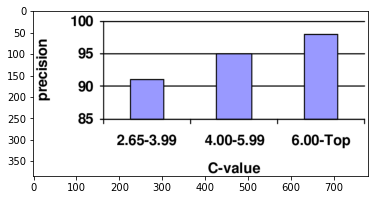

In [3]:
import skimage
from skimage import io
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from skimage import measure
import matplotlib.patches as patches
import pytesseract
import re
from icecream import ic
import cv2
from skimage import io, color
from CIEDE2000_git.ciede2000 import CIEDE2000

#showing the example image i will use in this notebook
img = io.imread(r"data\C02-1083-Figure-7-3x.png")
#img = io.imread(r"data\paper_ex.png")
plt.imshow(img)

C:\Users\fabio\AppData\Local\Temp\ipykernel_23276\245821701.py:22: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1200, 1200, 4) looks like that of an RGB image.
  thresh = threshold_otsu(img)


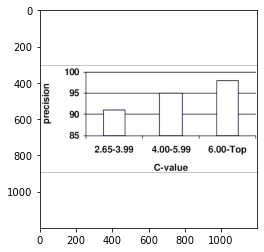

In [4]:
#this is the preprocessing pipeline as described in the paper Euroviz
def preprocessing(image_path):
    
    #opens the image
    img = io.imread(image_path)

    #expands the image to a square shape
    height, width,d = img.shape
    if width == height:
        pass
    elif width > height:
        missing = int((width - height)/2)
        img = np.pad(img,((missing,missing),(0,0),(0,0)))
    else:
        missing = int((height - width)/2)
        img = np.pad(img,((0,0),(missing,missing),(0,0)))
        
    #resizes the image to 1200x1200
    img = resize(img, (1200,1200, 4),anti_aliasing=True)

    #binarizing the image, otsus method is not made for color, but i think they did it that way and it looks like its working
    thresh = threshold_otsu(img)
    binary = img > thresh
    img[binary] = int(1)
    return img

plt.imshow(preprocessing(r"data\C02-1083-Figure-7-3x.png"),cmap = "gray")

In [5]:
#net modeled after:
#https://github.com/domoritz/darknet/blob/master/cfg/writing.cfg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        # i decided that all input images will be preprocessed like in the reverse ingeneering paper 
        # to 256x256 such that i dont need the croping layer
        # and i changed the kernel size of the last kernel to get the output of 64x64
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32, kernel_size=[7, 7],stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32, kernel_size=[3, 3],stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=32, kernel_size=[3, 3],stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=1, kernel_size=[2, 2],stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def ramp(self,x):
        #ramp activation function
        x[x < -1] = -1
        x[x > 1] = 1
        return x
    
    def forward(self, x):
        x = self.ramp(self.conv1(x))
        x = self.ramp(self.conv2(x))
        x = self.ramp(self.conv3(x))
        x = self.sigmoid(self.conv4(x))
        return x

C:\Users\fabio\AppData\Local\Temp\ipykernel_23276\245821701.py:22: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1200, 1200, 4) looks like that of an RGB image.
  thresh = threshold_otsu(img)


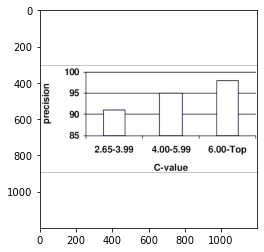

In [19]:
#loading the already trained net
# i trained this ned during my practical work course
net = torch.load(os.path.join("domoritz_results", "manual_saves", "domoritz_original_cnn.pt"),map_location=torch.device('cpu'))


processed_img = preprocessing(r"data\C02-1083-Figure-7-3x.png") #works really good

plt.imshow(processed_img,cmap='gray')

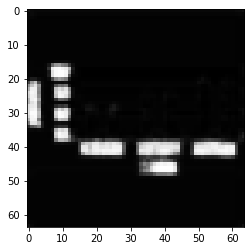

In [20]:
def get_heatmap(processed_img,net):
    """this function calculates the heatmap, by using the parameters:
    processed_img = an image which was processed by the function 'preprocessing'
    net = the net which is used to generate the heatmap"""
    grayscale = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img))
    res_gray = resize(grayscale, (255,255),anti_aliasing=True)
    inp = torch.from_numpy(np.array(res_gray.reshape(1,1,255,255),dtype=np.float32))
    heatmap = net(inp)
    return heatmap

heatmap = get_heatmap(processed_img,net)
plt.imshow(heatmap.detach().view(64,64),cmap='gray')

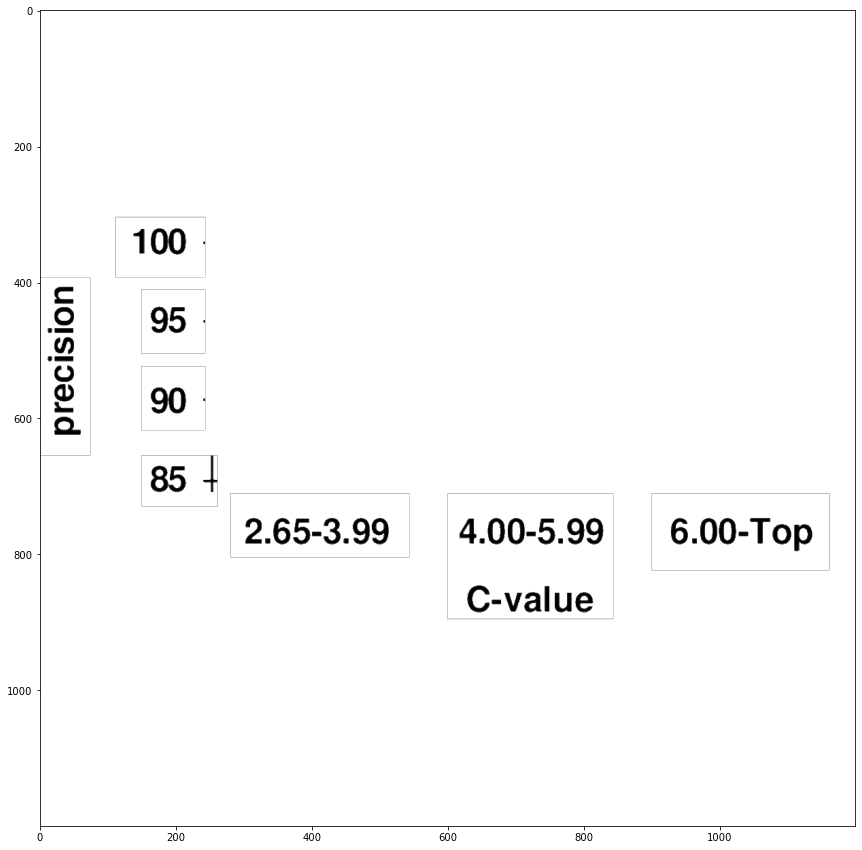

In [23]:
def apply_heatmap(heatmap, processed_img):
    #this function uses the heatmap to remove non text pixels
    
    big_heatmap = resize(heatmap.detach().numpy() , (1,1,1200,1200),order=0,anti_aliasing=False).reshape(1200,1200)
    
    #instead of just using a bitwise and operation like in the paper by poco and heer i decided to use 
    # contour lines with a very forgiving contour parameter and some extra added box height and width
    # to remove text pixels
    mask_arr = np.zeros((1200,1200))
    contours = measure.find_contours(big_heatmap.reshape(1200,1200),0.2,"low")
    for contour in contours:
        x = contour[:, 1]
        y = contour[:, 0]

        width = (x.max()-x.min())
        height = (y.max()-y.min())

        h_add_div = np.inf # but i decided to delete the added height and width, but this line is still here for fine tuning later maybe
        w_add_div = np.inf
        x_min = max(0,int(x.min() - width/w_add_div))
        x_max = min(1200,int(x.max() + width/w_add_div))
        y_min = max(0,int(y.min() - height/h_add_div))
        y_max = min(1200,int(y.max() + height/h_add_div))

        mask_arr[y_min:y_max,x_min:x_max] = 1
        
    processed_img[mask_arr < 0.6] = 0
    return processed_img


processed_img = apply_heatmap(heatmap, processed_img)
plt.figure(figsize = (15,15))
plt.imshow(processed_img,aspect=1)

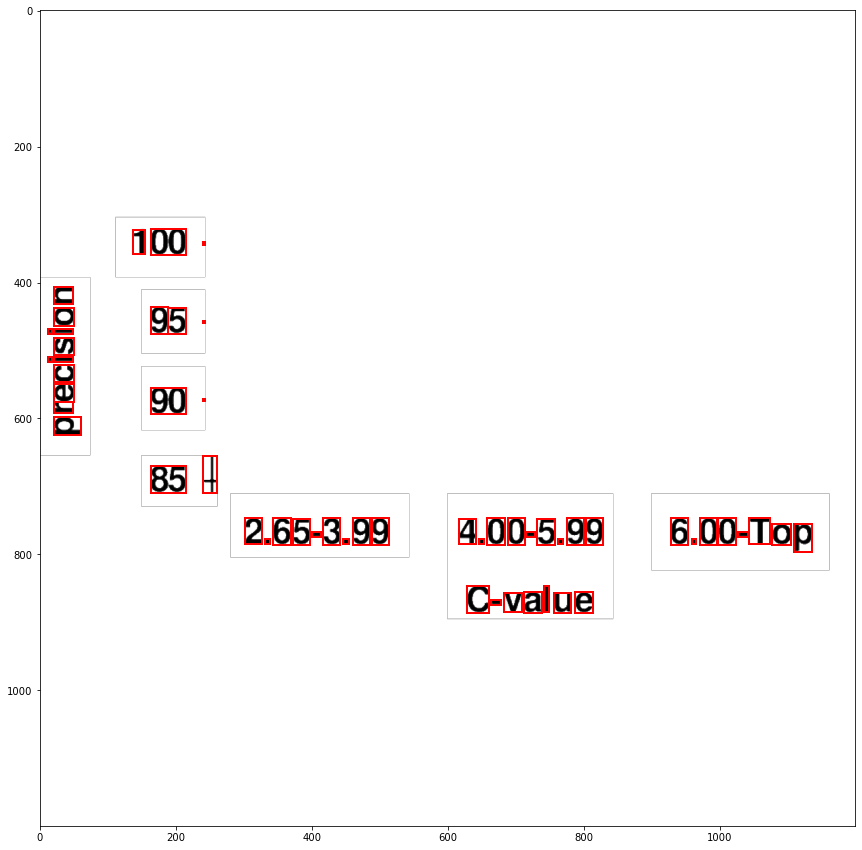

In [10]:
def get_bb(processed_img):
    
    #in this step i use a connected components algorithm to create bounding boxes around connected components
    grayscale = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img))
    img=np.array(grayscale<=0.9999, dtype = np.int8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img,8,cv2.CV_32S)
    
    #filtering the boxes
    bb = []
    for x,y,w,h,a in stats:
        x_min = x
        x_max = x+w
        y_min = y
        y_max = y+h
        #checking the aspect ratio and removing some boxes if needed
        if 1/10 <= w/h <= 10:
            if 4 <= a <= 2000:#changed 1000 to 2000, because it brings better results
                bb.append([x,y,w,h,a])

    return np.array(bb), labels

bb, labels = get_bb(processed_img)
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(processed_img, cmap=plt.cm.gray)
for i in range(0,len(bb)):
    x,y,w,h,area = bb[i, :]
    rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# kruskals algorithm

In [11]:
#from:
#https://www.geeksforgeeks.org/kruskals-minimum-spanning-tree-algorithm-greedy-algo-2/

# nodes are the candidate characters
#and the edge weights are the Euclidean distances between bounding box centers

# Python program for Kruskal's algorithm to find
# Minimum Spanning Tree of a given connected,
# undirected and weighted graph

from collections import defaultdict

# Class to represent a graph


class Graph:

    def __init__(self, vertices):
        self.V = vertices # No. of vertices
        self.graph = [] # default dictionary
        # to store graph

    # function to add an edge to graph
    def addEdge(self, u, v, w):
        self.graph.append([u, v, w])
        #self.m_graph.append([node1, node2, weight])

    # A utility function to find set of an element i
    # (uses path compression technique)
    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])

    # A function that does union of two sets of x and y
    # (uses union by rank)
    def union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)

        # Attach smaller rank tree under root of
        # high rank tree (Union by Rank)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot

        # If ranks are same, then make one as root
        # and increment its rank by one
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    # The main function to construct MST using Kruskal's
        # algorithm
    def KruskalMST(self):

        result = [] # This will store the resultant MST

        # An index variable, used for sorted edges
        i = 0

        # An index variable, used for result[]
        e = 0

        # Step 1: Sort all the edges in
        # non-decreasing order of their
        # weight. If we are not allowed to change the
        # given graph, we can create a copy of graph
        self.graph = sorted(self.graph,
                            key=lambda item: item[2])
        
        parent = []
        rank = []

        # Create V subsets with single elements
        for node in range(self.V):
            parent.append(node)
            rank.append(0)

        # Number of edges to be taken is equal to V-1
        while e < self.V - 1:

            # Step 2: Pick the smallest edge and increment
            # the index for next iteration
            u, v, w = self.graph[i]
            i = i + 1
            x = self.find(parent, u)
            y = self.find(parent, v)

            # If including this edge doesn't
            # cause cycle, include it in result
            # and increment the indexof result
            # for next edge
            if x != y:
                e = e + 1
                result.append([u, v, w])
                self.union(parent, rank, x, y)
            # Else discard the edge

        minimumCost = 0
        #print ("Edges in the constructed MST")
        for u, v, weight in result:
            minimumCost += weight
            #print("%d -- %d == %d" % (u, v, weight))
        #print("Minimum Spanning Tree" , minimumCost)
        return result

# Driver code
g = Graph(4)
g.addEdge(0, 1, 10)
g.addEdge(0, 2, 6)
g.addEdge(0, 3, 5)
g.addEdge(1, 3, 15)
g.addEdge(2, 3, 4)

# Function call
g.KruskalMST()

# This code is contributed by Neelam Yadav

[[2, 3, 4], [0, 3, 5], [0, 1, 10]]

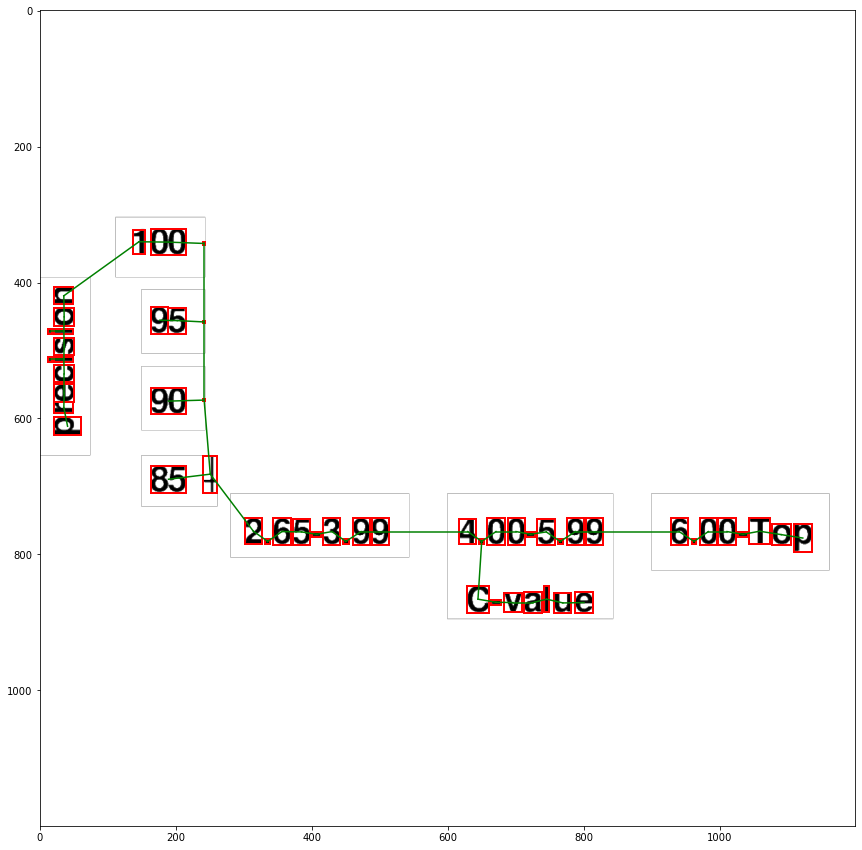

In [12]:
def create_MST(bb):
    #this fits an MST with krauksals algorithm around the bounding boxes
    g = Graph(len(bb))

    for node1 in range(0,len(bb)):
        for node2 in range(0,len(bb)):
            # node1, node2 = vertex name

            #calculating the euclidian distance
            x1,y1,w1,h1,a1 = bb[node1]
            x2,y2,w2,h2,a2 = bb[node2]

            mid1 = np.array([x1+w1/2,y1+h1/2])
            mid2 = np.array([x2+w2/2,y2+h2/2])

            eucl_dist = np.sqrt((mid1[0]-mid2[0])**2+ (mid1[1]-mid2[1])**2)

            #adding the edge to the graph
            g.addEdge(node1, node2, eucl_dist)

    return g.KruskalMST()

MST = create_MST(bb)

#printing the mst and boxes
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(processed_img, cmap=plt.cm.gray)
for i in range(0,len(bb)):
    x,y,w,h,area = bb[i, :]
    rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
for node1, node2, weight in MST:
    x1,y1,w1,h1,a1 = bb[node1]
    x2,y2,w2,h2,a2 = bb[node2]
    
    mid1 = np.array([x1+w1/2,y1+h1/2])
    mid2 = np.array([x2+w2/2,y2+h2/2])
    
    ax.plot([mid1[0],mid2[0]],[mid1[1],mid2[1]], color="green")

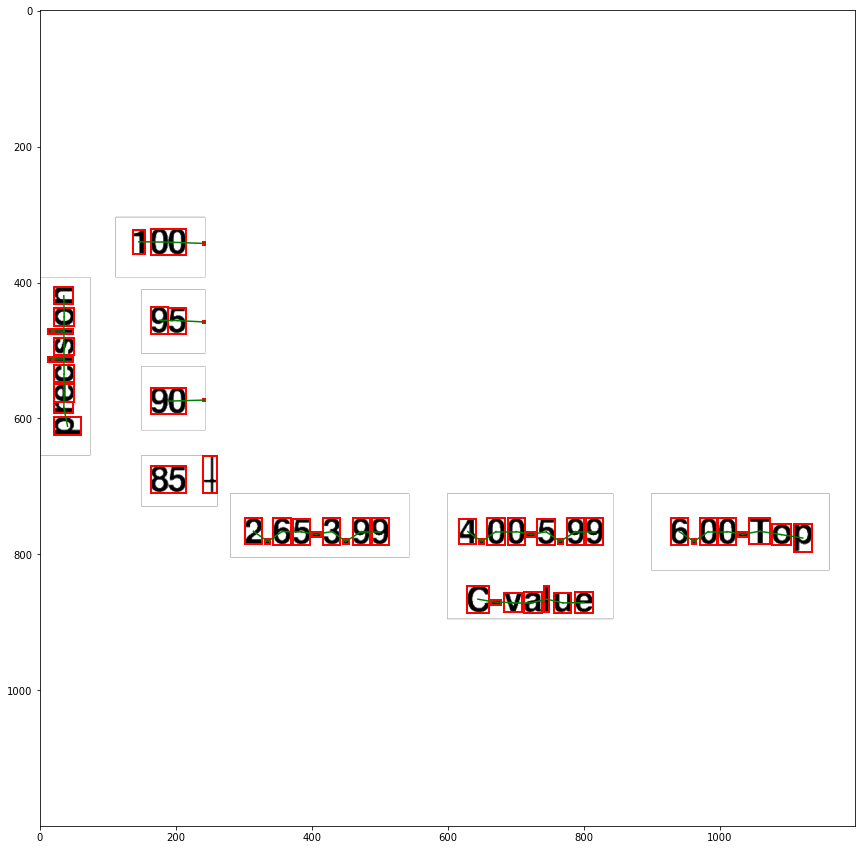

In [13]:
def prune(bb,MST):
    #pruning the tree:
    
    #pruning edges, which are to long
    length_set = np.array(bb[:,3])#changed the length set, to only include height
    l = np.argmax(np.bincount(length_set,minlength=0))
    cleaned_MST = []
    for i,[node1, node2, weight] in enumerate(MST):
        #discarding edges with >2l l
        if weight <= 1.5*l:
            cleaned_MST.append([node1, node2, weight])
         
    #discarding edges with to much overlap
    MST = np.array(cleaned_MST)  
    cleaned_MST = []
    for i in range(len(bb)):
        #calculating overlap
        relevant_edges = MST[(MST[:,0]==i) | (MST[:,1]==i)]
        for node1,node2,weight in relevant_edges:
            x1,y1,w1,h1,a1 = bb[int(node1)]
            x2,y2,w2,h2,a2 = bb[int(node2)]
            hor_over = min(-x1+x2+w2,-x2+x1+w1,w1,w2)
            ver_over = min(-y1+y2+h2,-y2+y1+h1,h1,h2)
            if hor_over>min(w1,w2)/2 or ver_over>min(h1,h2)/2:#what is w1,2,h1,2
                if not [node1,node2,weight] in cleaned_MST:
                    cleaned_MST.append([node1,node2,weight])
    
    #discarding edges with to high color difference
    cleaned_MST = []
    for i in range(len(bb)):
        relevant_edges = MST[(MST[:,0]==i) | (MST[:,1]==i)]
        for node1,node2,weight in relevant_edges:
            x1,y1,w1,h1,a1 = bb[int(node1)]
            x2,y2,w2,h2,a2 = bb[int(node2)]

            processed_img1 = processed_img[y1:y1+h1,x1:x1+w1,]
            grayscale1 = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img1))
            img1=np.array(grayscale1<=0.9999, dtype = np.int8)
            num_labels1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(img1,8,cv2.CV_32S)
            rgb1 = skimage.color.rgba2rgb(processed_img1[labels1!=0])
            lab1 = color.rgb2lab(rgb1)
            mean1 = np.mean(lab1,axis=0)

            processed_img2 = processed_img[y2:y2+h2,x2:x2+w2,]
            grayscale2 = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img2))
            img2=np.array(grayscale2<=0.9999, dtype = np.int8)
            num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(img2,8,cv2.CV_32S)     
            rgb2 = skimage.color.rgba2rgb(processed_img2[labels2!=0])
            lab2 = color.rgb2lab(rgb2)
            mean2 = np.mean(lab2,axis=0)

            color_diff = CIEDE2000(mean1,mean2)

            if color_diff <= 20:
                if not [node1,node2,weight] in cleaned_MST:
                    cleaned_MST.append([node1,node2,weight])

    return np.array(cleaned_MST)

MST = create_MST(bb)
MST = prune(bb,MST)

#printing the mst and boxes
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(processed_img, cmap=plt.cm.gray)
for i in range(0,len(bb)):
    x,y,w,h,area = bb[i, :]
    rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
for node1, node2, weight in MST:
    x1,y1,w1,h1,a1 = bb[int(node1)]
    x2,y2,w2,h2,a2 = bb[int(node2)]
    
    mid1 = np.array([x1+w1/2,y1+h1/2])
    mid2 = np.array([x2+w2/2,y2+h2/2])
    
    ax.plot([mid1[0],mid2[0]],[mid1[1],mid2[1]], color="green")

In [14]:
#using a connected components algorithm to get word boxes
#https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/

# Python program to print connected
# components in an undirected graph


class CC_Graph:

    # init function to declare class variables
    def __init__(self, V):
        self.V = V
        self.adj = [[] for i in range(V)]

    def DFSUtil(self, temp, v, visited):

        # Mark the current vertex as visited
        visited[v] = True

        # Store the vertex to list
        temp.append(v)

        # Repeat for all vertices adjacent
        # to this vertex v
        for i in self.adj[v]:
            if visited[i] == False:

                # Update the list
                temp = self.DFSUtil(temp, i, visited)
        return temp

    # method to add an undirected edge
    def addEdge(self, v, w):
        self.adj[v].append(w)
        self.adj[w].append(v)

    # Method to retrieve connected components
    # in an undirected graph
    def connectedComponents(self):
        visited = []
        cc = []
        for i in range(self.V):
            visited.append(False)
        for v in range(self.V):
            if visited[v] == False:
                temp = []
                cc.append(self.DFSUtil(temp, v, visited))
        return cc


# Driver Code
if __name__ == "__main__":

    # Create a graph given in the above diagram
    # 5 vertices numbered from 0 to 4
    g = CC_Graph(5)
    g.addEdge(1, 0)
    g.addEdge(2, 3)
    g.addEdge(3, 4)
    cc = g.connectedComponents()
    print("Following are connected components")
    print(cc)

# This code is contributed by Abhishek Valsan

Following are connected components
[[0, 1], [2, 3, 4]]


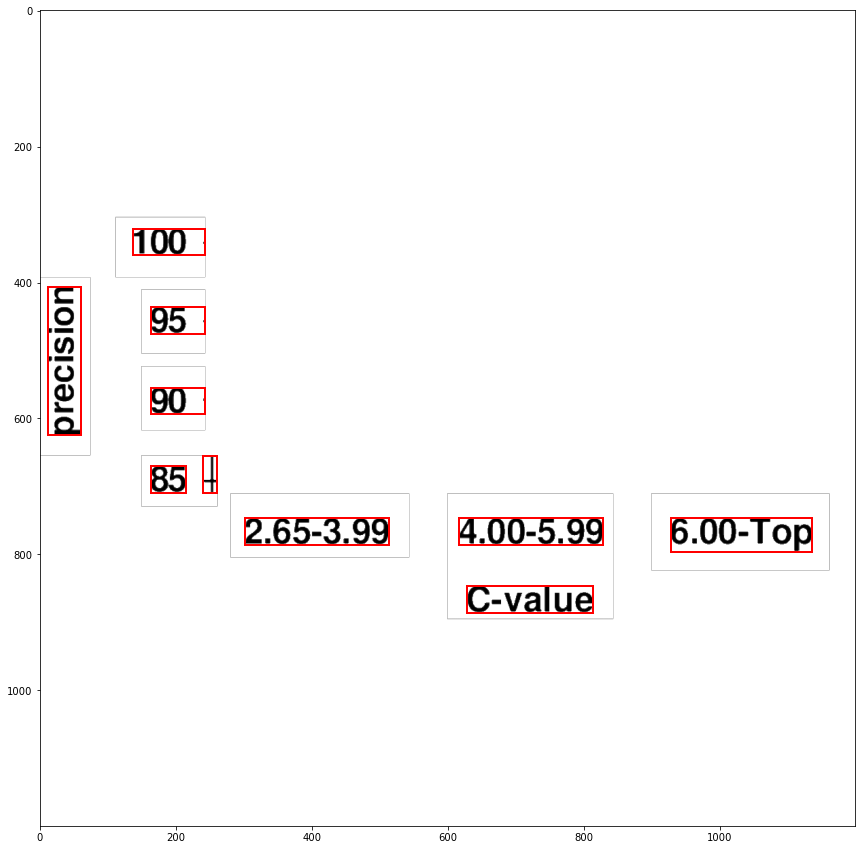

In [15]:
def create_word_boxes(MST,bb):
    #creates the word boxes by merging boxes wich have connecting edges in the MST
    ccg = CC_Graph(len(bb))

    for n1,n2,w in MST:
        ccg.addEdge(int(n1),int(n2))
    cc = ccg.connectedComponents()
    
    wbb = []
    for c in cc:
        values = []
        for node in c:
            x,y,w,h,a = bb[int(node)]
            values.append([x,y,x+w,y+h])
        values = np.array(values)
        x,y,xw,yh = values[:,0],values[:,1],values[:,2],values[:,3]
        wbb.append([x.min(),y.min(),xw.max()-x.min(),yh.max()-y.min()])
        
    return np.array(wbb)

MST = create_MST(bb)
MST = prune(bb,MST)
wbb = create_word_boxes(MST,bb)

#printing the mst and boxes
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(processed_img, cmap=plt.cm.gray)
for i in range(0,len(wbb)):
    x,y,w,h = wbb[i, :]
    rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ic| best_conf: 82.69460649999999
ic| best_conf: 96.195389
ic| best_conf: 54.463093
ic| best_conf: 85.24333949999999
ic| best_conf: 78.686722
ic| best_conf: 96.698982
ic| best_conf: 91.815361
ic| best_conf: 91.298363
ic| best_conf: 90.963226
ic| best_conf: 86.284462


['100 -\n',
 'precision\n',
 'O5 .\n',
 '- 06\n',
 'T\n',
 '85\n',
 '2.65-3.99\n',
 '4.00-5.99\n',
 '6.00-Top\n',
 'C-value\n']

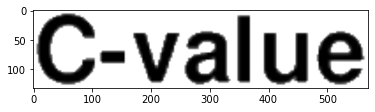

In [16]:
def ocr(wbb,img):
    #this function calculates the words in the bounding boxes
    
    all_text = []
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    
    #go through every word box
    for x,y,w,h in wbb:
        
        # crop a word rectangle from the binary image
        a = 2 # a is some extra box width
        text_img = processed_img[y-a:y+h+a,x-a:x+w+a]
        gray = skimage.color.rgb2gray(skimage.color.rgba2rgb(text_img))
        rgb = skimage.color.rgba2rgb(text_img)
        
        #scale it by a factor of 3
        big_img = resize(text_img, (text_img.shape[0]*3,text_img.shape[1]*3,4),anti_aliasing=True)

        #We run Tesseract multiple times with the image rotated at different angles
        #this part just rotates the image and then takes the rotation, in which tesseract is most confident in
        best_conf = -1
        best_angle = 0
        
        for angle in [0,90,180,270]:
            img = skimage.transform.rotate(rgb,angle,True)
            out = pytesseract.image_to_data((img*255).astype(np.uint8),output_type=pytesseract.Output.DICT,config="--psm 7")
            
            #calculating average confidence if not -1
            n = 0
            summ = 0
            for val in out["conf"]:
                if val != "-1":
                    n+=1
                    summ += float(val)
            if n == 0:
                n = 1
            conf = summ/n
            
            #saving the best confidence
            if best_conf < conf:
                best_conf = conf
                best_angle = angle
        
        #looking for the content and adding the patch
        rgb = skimage.transform.rotate(big_img,best_angle,True) 
        img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 7")#6#7 with rotation #11
        plt.imshow(rgb)
        ax.add_patch(rect)
        all_text.append(img_content)
    return all_text

ocr(wbb,processed_img)

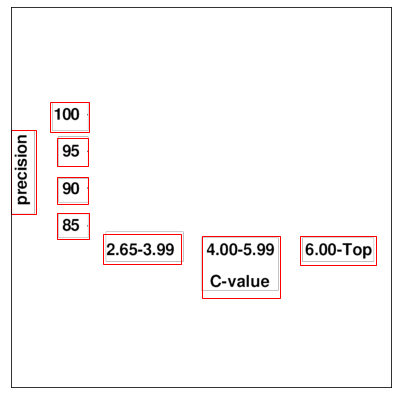

['100 -\n',
 'precision\n',
 '9\n',
 '90\n',
 '&\n',
 '2.65-3.99\n',
 'came\n',
 '6.00-Top\n']

In [107]:
def display_bounding_boxes(heatmap, contour_parameter):
    """this function displays the bounding boxes in a plot
    parameters:
    heatmap = the heatmap
    contour_parameter = parameter, which decides how strict the contour lines are drawn
    returns:
    the text found, as a list
    and displays the bounding boxes"""
    
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    
    big_heatmap = resize(heatmap.detach(), (1,1,1200,1200),anti_aliasing=True)
    r = big_heatmap.reshape(1200,1200)
    contours = measure.find_contours(r,contour_parameter,"low")
    # Display the image
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(processed_img, cmap=plt.cm.gray)
    
    all_text = []
    #plot all bounding boxes 
    for contour in contours:
        
        #ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        x = contour[:, 1]
        y = contour[:, 0]
        width = (x.max()-x.min())
        height = (y.max()-y.min())

        if width > 1 and height > 1:
            #ic(width, height, x.min(),y.min())
            rect = patches.Rectangle((x.min(), y.min()), width, height, linewidth=1, edgecolor='r', facecolor='none')
            text_img = processed_img[int(y.min()):int(y.max()),int(x.min()):int(x.max())]
            gray = skimage.color.rgb2gray(skimage.color.rgba2rgb(text_img))
            rgb = skimage.color.rgba2rgb(text_img)
            
            #this part just rotates the image and then takes the rotation, in which tesseract is most confident in
            best_conf = -1
            best_angle = 0
            for angle in [0,90,180,270]:
                img = skimage.transform.rotate(rgb,angle,True)
                out = pytesseract.image_to_data((img*255).astype(np.uint8),output_type=pytesseract.Output.DICT,config="--psm 7")
                #calculating average confidence if not -1
                n = 0
                summ = 0
                for val in out["conf"]:
                    if val != "-1":
                        n+=1
                        summ += float(val)
                if n == 0:
                    n = 1
                conf = summ/n

                #saving the best confidence
                if best_conf < conf:
                    best_conf = conf
                    best_angle = angle
                    
            #looking for the content and adding the patch
            rgb = skimage.transform.rotate(rgb,best_angle,True) 
            img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 7")#6#7 with rotation #11
            ax.add_patch(rect)
            all_text.append(img_content)
            
            
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    return all_text

display_bounding_boxes(heatmap, 0.3)

In [38]:
#@continue: 
# - deleting boxes, with no words

array([ 94, 241,   7,  26,  83], dtype=int32)

In [ ]:
#https://stackoverflow.com/questions/23979146/check-if-numpy-array-is-in-list-of-numpy-arrays
#test for exact equality
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if array_equal(elem, myarr)), False)

def get_word_boxes(bb,MST):
    wbb = []
    for i in range(len(bb)):
        relevant_edges = MST[(MST[:,0]==i) | (MST[:,1]==i)]
        max_y = []
        max_x = []
        min_y = []
        min_x = []
        
        #walking every connection to get a word box
        visited_nodes = [i]
        visited_edges = list(relevant_edges)
        current_edges = list(relevant_edges)
        #ic(visited_nodes,visited_edges,current_edges)
        for node1,node2,weight in current_edges:
            if node1 not in visited_nodes:
                visited_nodes.append(node1)
                for edge in list(MST[(MST[:,0]==node1) | (MST[:,1]==node1)]):
                    #ic(edge)
                    if arreq_in_list(edge,visited_edges):
                        current_edges.append(edge)
            if node2 not in visited_nodes:
                visited_nodes.append(node2)
                for edge in list(MST[(MST[:,0]==node2) | (MST[:,1]==node2)]):
                    #ic(edge, visited_edges)
                    if arreq_in_list(edge,visited_edges):
                        current_edges.append(edge)
                        
            if arreq_in_list(np.array([node1,node2,weight]),visited_edges):
                visited_edges.append([node1,node2,weight])
            
            x1,y1,w1,h1,a1 = bb[int(node1)]
            x2,y2,w2,h2,a2 = bb[int(node2)]
            max_y.extend([y1+h1,y2+h2])
            max_x.extend([x1+w1,x2+w2])
            min_y.extend([y1,y2])
            min_x.extend([x1,x2])
            
            #ic(current_edges)
            
        #ic(max_y,max_x,min_y,min_x)
        if min_x != []:
            x = min(min_x)
            y = min(min_y)
            w = max(max_x)-x
            h = max(max_y)-y
            if [x,y,w,h,w*h] not in wbb:
                wbb.append([x,y,w,h,w*h])
    #wbb = bb
    return np.array(wbb)


MST = create_MST(bb)
MST = prune(bb,MST)
wbb = get_word_boxes(bb,MST)

#printing the mst and boxes
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(processed_img, cmap=plt.cm.gray)
for i in range(0,len(wbb)):
    #ic(x,y,w,h,area)
    x,y,w,h,area = wbb[i, :]
    rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

In [ ]:
a = np.array([ 1.        ,  3.        , 16.71077497])
ic(list(a))

In [ ]:
from numpy import array, array_equal, allclose

myarr0 = array([1, 0])
myarr1 = array([3.4499999, 3.2])
mylistarr = [array([1, 2, 3]), array([1, 0]), array([3.45, 3.2])]

#test for identity:
def is_arr_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if elem is myarr), False)

print(is_arr_in_list(mylistarr[2], mylistarr)) #->True
print(is_arr_in_list(myarr0, mylistarr)) #->False
#myarr0 is equal to mylistarr[1], but it is not the same object!

#test for exact equality
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if array_equal(elem, myarr)), False)

print(arreq_in_list(myarr0, mylistarr)) # -> True
print(arreq_in_list(myarr1, mylistarr)) # -> False

#test for approximate equality (for floating point types)
def arreqclose_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if elem.size == myarr.size and allclose(elem, myarr)), False)

print(arreqclose_in_list(myarr1, mylistarr)) #-> True

In [ ]:
def ocr(MST,):
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    # crop a word rectangle from the binary image
    
    #scale it by a factor of 3
    return

In [ ]:
bb

In [ ]:
bb[1]

In [ ]:
MST = create_MST(bb)
MST = prune(bb,MST)   
#ic(MST)  
#discarding edges with color 
cleaned_MST = []
for i in range(len(bb)):
    relevant_edges = MST[(MST[:,0]==i) | (MST[:,1]==i)]
    for node1,node2,weight in relevant_edges:
        x1,y1,w1,h1,a1 = bb[int(node1)]
        x2,y2,w2,h2,a2 = bb[int(node2)]
            
        processed_img1 = processed_img[y1:y1+h1,x1:x1+w1,]
        grayscale1 = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img1))
        img1=np.array(grayscale1<=0.9999, dtype = np.int8)
        num_labels1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(img1,8,cv2.CV_32S)
        rgb1 = skimage.color.rgba2rgb(processed_img1[labels1!=0])
        lab1 = color.rgb2lab(rgb1)
        mean1 = np.mean(lab1,axis=0)
        
        processed_img2 = processed_img[y2:y2+h2,x2:x2+w2,]
        grayscale2 = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img2))
        img2=np.array(grayscale2<=0.9999, dtype = np.int8)
        num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(img2,8,cv2.CV_32S)     
        rgb2 = skimage.color.rgba2rgb(processed_img2[labels2!=0])
        lab2 = color.rgb2lab(rgb2)
        mean2 = np.mean(lab2,axis=0)
        
        color_diff = CIEDE2000(mean1,mean2)
        
        if color_diff <= 20:
            if not [node1,node2,weight] in cleaned_MST:
                cleaned_MST.append([node1,node2,weight])
        
        #CIEDE2000((50, 10, 80), (50, 0.0000, -200))
    #if i ==2:
    #    break
        
    #removing boxes which have no more connection
#plt.imshow(labels1)

MST = np.array(cleaned_MST)
ic(len(MST))
#printing the mst and boxes
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(processed_img, cmap=plt.cm.gray)
for i in range(0,len(bb)):
    #ic(x,y,w,h,area)
    x,y,w,h,area = bb[i, :]
    rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
for node1, node2, weight in MST:
    #ic(node1,node2,weight)
    x1,y1,w1,h1,a1 = bb[int(node1)]
    x2,y2,w2,h2,a2 = bb[int(node2)]
    
    mid1 = np.array([x1+w1/2,y1+h1/2])
    mid2 = np.array([x2+w2/2,y2+h2/2])
    
    ax.plot([mid1[0],mid2[0]],[mid1[1],mid2[1]], color="green")

In [ ]:
from skimage import io, color
import numpy as np
lab = color.rgb2lab(np.random.uniform(0,255,size =(10000,3)))
lab

In [ ]:
import sys
sys.getsizeof(lab)

In [ ]:
from skimage import io, color
from CIEDE2000_git.ciede2000 import CIEDE2000

print(CIEDE2000((50, 10, 80), (50, 0.0000, -200)))

In [ ]:
np.mean(np.random.uniform(0,255,size =(10000,3)),axis=0)

In [ ]:
x1= 62
y1= 384
w1= 16
h1= 25
a1= 160
x2=81
y2= 405
w2= 4
h2=4
a2= 12
plt.imshow(processed_img[y1:y1+h1,x1:x1+w1,])

In [ ]:
plt.imshow(processed_img)#[62:160,405:500])

In [ ]:
plt.imshow(processed_img[62:160,:])

In [ ]:
1194**2

In [ ]:
# Applying cv2.connectedComponents() 
grayscale = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img))
img=np.array(grayscale<=0.99, dtype = np.int8)
num_labels, labels = cv2.connectedComponents(img,connectivity =4)

In [ ]:
1200*1200/(254*254)

In [ ]:
low_res[0][0]

In [ ]:
plt.figure(figsize = (15,15))
low_res = resize(grayscale, (200,200),anti_aliasing=True)
plt.imshow(low_res<=0.99)

In [ ]:
#need node1, node2, weight
g = Graph(len(bb))

for node1 in range(0,len(bb)):
    for node2 in range(0,len(bb)):
        # node1, node2 = vertex name
        
        #calculating the euclidian distance
        x1,y1,w1,h1,a1 = bb[node1]
        x2,y2,w2,h2,a2 = bb[node2]
        
        #mid1 = np.array([x1-h1/2,y1+w1/2])
        #mid2 = np.array([x2-h2/2,y2+w2/2])
        
        mid1 = np.array([x1+w1/2,y1+h1/2])
        mid2 = np.array([x2+w2/2,y2+h2/2])
        
        eucl_dist = np.sqrt((mid1[0]-mid2[0])**2+ (mid1[1]-mid2[1])**2)
        
        #adding the edge to the graph
        g.addEdge(node1, node2, eucl_dist)
        
MST = g.KruskalMST()

#printing the mst and boxes
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(processed_img, cmap=plt.cm.gray)
for i in range(0,len(bb)):
    #ic(x,y,w,h,area)
    x,y,w,h,area = bb[i, :]
    rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
for node1, node2, weight in MST:
    x1,y1,w1,h1,a1 = bb[node1]
    x2,y2,w2,h2,a2 = bb[node2]
    
    mid1 = np.array([x1+w1*1,y1+h1*1])
    mid2 = np.array([x2+w2*1,y2+h2*1])
    
    ax.plot([mid1[0],mid2[0]],[mid1[1],mid2[1]], color="green")

In [ ]:
n=100
l=-100
plt.figure(figsize = (15,15))
plt.imshow(labels != 0, cmap = "gray")

In [ ]:
componentMask = (labels == 0) * 255
plt.figure(figsize = (15,15))
plt.imshow(componentMask)

In [ ]:
# Applying cv2.connectedComponents() 
grayscale = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img))
img=np.array(grayscale<=0.9999, dtype = np.int8)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img,4,cv2.CV_32S)

fig, ax = plt.subplots(figsize = (15,15))

ax.imshow(processed_img, cmap=plt.cm.gray)
for i in range(0,len(stats)):
    #ic(x,y,w,h,area)
    x = stats[i, 0]
    y = stats[i, 1]
    w = stats[i, 2]
    h = stats[i, 3]
    area = stats[i, 4]
    rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [ ]:
output = img
for x,y,w,h,a in stats:
    output = cv2.rectangle(output, (x, y), (w,h), (0, 255, 0), 3)
plt.figure(figsize = (15,15))
plt.imshow(output,cmap="gray")

In [ ]:
cv2.CC_STAT_TOP

In [ ]:
centroids

In [ ]:
stats

In [ ]:
processed_img = preprocessing(r"data\00025.png")
heatmap = get_heatmap(processed_img,net)
big_heatmap = resize(heatmap.detach().numpy() , (1,1,1200,1200),order=0,anti_aliasing=False).reshape(1200,1200)
#big_heatmap = np.array([big_heatmap]*4).reshape(1200,1200,4,order = "C")
processed_img = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img))
#processed_img[big_heatmap < 0.6] = 0
#big_heatmap[big_heatmap >= 0.6] = 1

plt.imshow(processed_img,cmap='gray')

In [ ]:
mask_arr = np.zeros((1200,1200))
contours = measure.find_contours(big_heatmap.reshape(1200,1200),0.3,"low")
for contour in contours:
    x = contour[:, 1]
    y = contour[:, 0]
    
    width = (x.max()-x.min())
    height = (y.max()-y.min())
    
    h_add_div = 10
    w_add_div = 10
    x_min = max(0,int(x.min() - width/w_add_div))
    x_max = min(1200,int(x.max() + width/w_add_div))
    y_min = max(0,int(y.min() - height/h_add_div))
    y_max = min(1200,int(y.max() + height/h_add_div))
    
    #ic(x.min(),x.max(),y.min(),y.max())
    mask_arr[y_min:y_max,x_min:x_max] = 1

plt.imshow(mask_arr,cmap='gray')

In [ ]:
processed_img[mask_arr < 0.6] = 0
plt.imshow(processed_img,cmap='gray')

In [ ]:
import numpy as np

arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])

print(arr[1, 1:4])

In [ ]:
def display_bounding_boxes(heatmap, contour_parameter):
    """this function displays the bounding boxes in a plot
    parameters:
    heatmap = the heatmap
    contour_parameter = parameter, which decides how strict the contour lines are drawn
    returns:
    the text found, as a list
    and displays the bounding boxes"""
    
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    
    big_heatmap = resize(heatmap.detach(), (1,1,1200,1200),anti_aliasing=True)
    r = big_heatmap.reshape(1200,1200)
    contours = measure.find_contours(r,contour_parameter,"low")
    # Display the image
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(processed_img, cmap=plt.cm.gray)
    
    all_text = []
    #plot all bounding boxes 
    for contour in contours:
        
        #ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        x = contour[:, 1]
        y = contour[:, 0]
        width = (x.max()-x.min())
        height = (y.max()-y.min())

        if width > 1 and height > 1:
            ic(width, height, x.min(),y.min())
            rect = patches.Rectangle((x.min(), y.min()), width, height, linewidth=1, edgecolor='r', facecolor='none')
            text_img = processed_img[int(y.min()):int(y.max()),int(x.min()):int(x.max())]
            gray = skimage.color.rgb2gray(skimage.color.rgba2rgb(text_img))
            rgb = skimage.color.rgba2rgb(text_img)
            
            #this part just rotates the image and then takes the rotation, in which tesseract is most confident in
            best_conf = -1
            best_angle = 0
            for angle in [0,90,180,270]:
                img = skimage.transform.rotate(rgb,angle,True)
                out = pytesseract.image_to_data((img*255).astype(np.uint8),output_type=pytesseract.Output.DICT,config="--psm 6")
                #calculating average confidence if not -1
                n = 0
                summ = 0
                for val in out["conf"]:
                    if val != "-1":
                        n+=1
                        summ += float(val)
                if n == 0:
                    n = 1
                conf = summ/n

                #saving the best confidence
                if best_conf < conf:
                    best_conf = conf
                    best_angle = angle
                    
            #looking for the content and adding the patch
            rgb = skimage.transform.rotate(rgb,best_angle,True) 
            img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 6")#6#7 with rotation #11
            ax.add_patch(rect)
            all_text.append(img_content)
            
            
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    return all_text

display_bounding_boxes(heatmap, 0.1)

In [ ]:
def display_bounding_boxes_without_param(heatmap):
    """this function is really experimental, i tried to make the choosing of the contour parameter
    automatic, it works here, but more often than not it doesnt work. This function should just show, that it is possible to 
    choose this parameter automatically, even though most of the times it is between 0.2 and 0.4
    
    parameters:
    heatmap = the heatmap
    returns:
    the text found, as a list
    and displays the bounding boxes"""
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    big_heatmap = resize(heatmap.detach(), (1,1,1200,1200),anti_aliasing=True)
    r = big_heatmap.reshape(1200,1200)

    # Display the image and plot all contours found
    splitable = True
    contour_parameter = 0.2
    while splitable:
        contours = measure.find_contours(r,contour_parameter,"low")
        tx = []
        splitable = False
        fig, ax = plt.subplots()
        ax.imshow(processed_img, cmap=plt.cm.gray)
        ax.set_title(f"contour_param: {contour_parameter}")
        for contour in contours:
            #ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
            #if splitable:
                #break
            x = contour[:, 1]
            y = contour[:, 0]
            width = (x.max()-x.min())
            height = (y.max()-y.min())

            if width > 1 and height > 1:
                rect = patches.Rectangle((x.min(), y.min()), width, height, linewidth=1, edgecolor='r', facecolor='none')
                text_img = processed_img[int(y.min()):int(y.max()),int(x.min()):int(x.max())]
                gray = skimage.color.rgb2gray(skimage.color.rgba2rgb(text_img))
                rgb = skimage.color.rgba2rgb(text_img)

                img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 6")#6#7 with rotation #11

                if "\n" in img_content:
                    if img_content.split("\n")[1] != "":
                        best_conf = -1
                        best_angle = 0
                        for angle in [0,90,180,270]:
                            img = skimage.transform.rotate(rgb,angle,True)
                            out = pytesseract.image_to_data((img*255).astype(np.uint8),output_type=pytesseract.Output.DICT,config="--psm 6")
                            #calculating average confidence if not -1
                            n = 0
                            summ = 0
                            for val in out["conf"]:
                                if val != "-1":
                                    n+=1
                                    summ += float(val)
                            if n == 0:
                                n = 1
                            conf = summ/n
                            #saving the best confidence
                            if best_conf < conf:
                                best_conf = conf
                                best_angle = angle
                        rgb = skimage.transform.rotate(rgb,best_angle,True) 
                        img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 6")#6#7 with rotation #11
                        if "\n" in img_content:
                            if img_content.split("\n")[1] != "":
                                splitable = True


                tx.append(img_content)
                ax.add_patch(rect)
        contour_parameter += 0.05


    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    return tx


display_bounding_boxes_without_param(heatmap)